<a href="https://colab.research.google.com/github/smf-9000/images-through-ML/blob/main/resNet50TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# just for practice, I used here pretrained weights from tfResNet50 model.
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## dataset


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# !mkdir /content/dataset_2
# !unzip "/content/drive/MyDrive/MY-WORK/datasets/image data of Natural Scenes around the world [kaggle]/archive.zip" -d /content/dataset_2
!unzip "/content/drive/MyDrive/dataset_shortcuts/archive.zip" -d /content/dataset_2

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
train_ds = train_data_gen.flow_from_directory(
        '/content/dataset_2/seg_train/seg_train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 14034 images belonging to 6 classes.


In [ ]:
val_ds = test_data_gen.flow_from_directory(
        '/content/dataset_2/seg_test/seg_test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [ ]:
class_names = train_ds.class_indices
print('class_names', class_names)
no_of_classes = len(class_names)
print('no_of_classes', no_of_classes)

class_names {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
no_of_classes 6




```
# -----------------------------------------------------------
```



## code

In [ ]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
# plt.figure(figsize=(10, 10))
# image = train_ds.next()[0]
# for i in range(9):
#   augmented_images = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_images[0].numpy().astype("uint8"))
#   plt.axis("off")

In [ ]:
def id_block(input_tensor, kernel_size, filters, L, B):
  name_pre = 'conv' + str(L+1) + '_' + 'block' + str(B)

  filters_1, filters_2, filters_3 = filters
  
  # whenever we use resNet, next three lines are always go together !!!!!
  X = layers.Conv2D(filters = filters_1, kernel_size = (1, 1), strides = (1,1), name=name_pre + '_1_conv')(input_tensor)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_1_bn')(X)
  X = layers.Activation('relu', name=name_pre + '_1_relu')(X)

  X = layers.Conv2D(filters = filters_2, kernel_size = kernel_size, strides = (1,1), padding = 'same', name=name_pre + '_2_conv')(X)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_2_bn')(X)
  X = layers.Activation('relu', name=name_pre + '_2_relu')(X)

  X = layers.Conv2D(filters = filters_3, kernel_size = (1, 1), strides = (1,1), name=name_pre + '_3_conv')(X)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_3_bn')(X)

  X = layers.Add(name=name_pre + '_add')([X, input_tensor])
  X = layers.Activation('relu', name=name_pre + '_3_relu')(X)  # !!!!!
  
  return X

In [ ]:
# when X is different shape than X_shortcut !!!!!
def conv_block(input_tensor, kernel_size, filters, L, B, strides = (2,2)):
  name_pre = 'conv' + str(L+1) + '_' + 'block' + str(B)

  filters_1, filters_2, filters_3 = filters
  
  X = layers.Conv2D(filters = filters_1, kernel_size = (1, 1), strides = strides, name=name_pre + '_1_conv')(input_tensor)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_1_bn')(X)
  X = layers.Activation('relu', name=name_pre + '_1_relu')(X)

  X = layers.Conv2D(filters = filters_2, kernel_size = kernel_size, strides = (1,1), padding = 'same', name=name_pre + '_2_conv')(X)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_2_bn')(X)
  X = layers.Activation('relu', name=name_pre + '_2_relu')(X)

  X = layers.Conv2D(filters = filters_3, kernel_size = (1, 1), strides = (1,1), name=name_pre + '_3_conv')(X)
  X = layers.BatchNormalization(axis = 3, name=name_pre + '_3_bn')(X)

  # !!!!!
  X_shortcut = layers.Conv2D(filters = filters_3, kernel_size = (1, 1), strides = strides, name=name_pre + '_0_conv')(input_tensor)
  X_shortcut = layers.BatchNormalization(axis = 3, name=name_pre + '_0_bn')(X_shortcut)

  X = layers.Add(name=name_pre + '_add')([X, X_shortcut])
  X = layers.Activation('relu', name=name_pre + '_3_relu')(X) # !!!!!
  
  return X


# ResNet 50 

In [ ]:
def ResNet_50(input_shape=(224, 224, 3), classes=no_of_classes):

  X_input = layers.Input(input_shape)

  X = data_augmentation(X_input)
  X = layers.experimental.preprocessing.Rescaling(1./255)(X)

  X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', name = 'conv1_conv')(X) 
  X = layers.BatchNormalization(axis=3, name = 'conv1_bn')(X) 
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)

  X = conv_block(X, kernel_size=(3,3), filters=[64, 64, 256], L=1, B=1, strides=(1, 1))
  X = id_block(X, kernel_size=(3,3), filters=[64, 64, 256], L=1, B=2) 
  X = id_block(X, kernel_size=(3,3), filters=[64, 64, 256], L=1, B=3)

  X = conv_block(X, kernel_size=(3,3), filters=[128, 128, 512], L=2, B=1)
  X = id_block(X, kernel_size=(3,3), filters=[128, 128, 512], L=2, B=2)
  X = id_block(X, kernel_size=(3,3), filters=[128, 128, 512], L=2, B=3)
  X = id_block(X, kernel_size=(3,3), filters=[128, 128, 512], L=2, B=4)

  X = conv_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=1)
  X = id_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=2)
  X = id_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=3)
  X = id_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=4)
  X = id_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=5)
  X = id_block(X, kernel_size=(3,3), filters=[256, 256, 1024], L=3, B=6)

  X = conv_block(X, kernel_size=(3,3), filters=[512, 512, 2048], L=4, B=1)
  X = id_block(X, kernel_size=(3,3), filters=[512, 512, 2048], L=4, B=2)
  X = id_block(X, kernel_size=(3,3), filters=[512, 512, 2048], L=4, B=3)

  X = layers.AveragePooling2D((7,7), strides=(7,7))(X)

  X = layers.Flatten()(X)
  X = layers.Dense(2048, activation='relu')(X)
  X = layers.Dropout(rate=0.4)(X)
  X = layers.Dense(512, activation='relu')(X)
  X = layers.Dropout(rate=0.4)(X)
  X = layers.Dense(classes, name='fc' + str(classes))(X) # activation='softmax',
  
  model = Model(inputs = X_input, outputs = X, name='resNet_50')

  return model


In [ ]:
model = ResNet_50(input_shape = (224, 224, 3), classes = no_of_classes)

In [ ]:
# model.summary()

In [ ]:
# -----------------------------------------------------------

## trLearning

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
# base_model.summary()

In [ ]:
LAYERS = {}
for layer in base_model.layers:
  LAYERS[layer.name] = layer.get_weights()
LAYERS.keys()

dict_keys(['input_7', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn',

In [ ]:
for layer in model.layers:
  l_name = layer.name
  if l_name in LAYERS:
    # print('-------------', l_name)
    layer.set_weights(LAYERS[l_name])
    layer.trainable = False

In [ ]:
# -----------------------------------------------------------

## restOfCode

In [ ]:
# training for dense layers

In [ ]:
model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [ ]:
history = model.fit(
                  train_ds, 
                  epochs = 5, 
                  batch_size = batch_size, 
                  validation_data=val_ds, 
                  validation_batch_size=batch_size) 

Epoch 1/5
220/220 [==============================] - 77s 338ms/step - loss: 1.5786 - accuracy: 0.3024 - val_loss: 1.3753 - val_accuracy: 0.3707
Epoch 2/5
220/220 [==============================] - 74s 335ms/step - loss: 1.3944 - accuracy: 0.3851 - val_loss: 1.2704 - val_accuracy: 0.4283
Epoch 3/5
220/220 [==============================] - 74s 336ms/step - loss: 1.3431 - accuracy: 0.4052 - val_loss: 1.2388 - val_accuracy: 0.4573
Epoch 4/5
220/220 [==============================] - 74s 337ms/step - loss: 1.3076 - accuracy: 0.4326 - val_loss: 1.2022 - val_accuracy: 0.4763
Epoch 5/5
220/220 [==============================] - 74s 336ms/step - loss: 1.2917 - accuracy: 0.4416 - val_loss: 1.2096 - val_accuracy: 0.4603


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

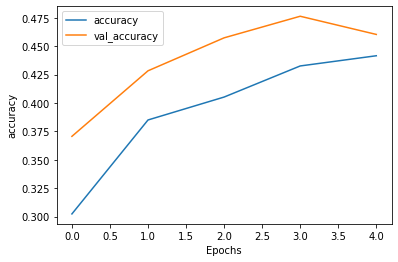

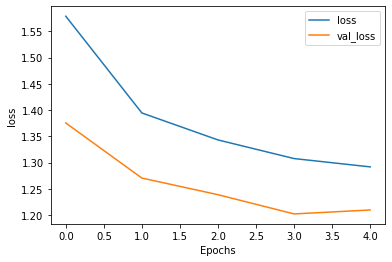

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, "loss")

In [ ]:
preds = model.evaluate(val_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

47/47 [==============================] - 13s 267ms/step - loss: 1.2096 - accuracy: 0.4603
Loss = 1.2096443176269531
Test Accuracy = 0.46033334732055664


In [ ]:
# -----------------------------------------------------------

In [ ]:
# training for whole network

In [ ]:
for layer in model.layers:
  layer.trainable = True    

In [ ]:
model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [ ]:
history = model.fit(
                  train_ds, 
                  epochs = 15, 
                  batch_size = batch_size, 
                  validation_data=val_ds, 
                  validation_batch_size=batch_size) 

Epoch 1/15
220/220 [==============================] - 212s 940ms/step - loss: 9.3893 - accuracy: 0.4332 - val_loss: 28.7640 - val_accuracy: 0.1460
Epoch 2/15
220/220 [==============================] - 206s 935ms/step - loss: 0.8848 - accuracy: 0.6438 - val_loss: 15.3797 - val_accuracy: 0.2693
Epoch 3/15
220/220 [==============================] - 207s 939ms/step - loss: 0.6582 - accuracy: 0.7448 - val_loss: 1.9547 - val_accuracy: 0.5560
Epoch 4/15
220/220 [==============================] - 207s 940ms/step - loss: 0.5374 - accuracy: 0.8022 - val_loss: 0.7149 - val_accuracy: 0.7480
Epoch 5/15
220/220 [==============================] - 207s 941ms/step - loss: 0.4420 - accuracy: 0.8417 - val_loss: 0.4464 - val_accuracy: 0.8417
Epoch 6/15
220/220 [==============================] - 207s 940ms/step - loss: 0.3673 - accuracy: 0.8664 - val_loss: 0.3844 - val_accuracy: 0.8683
Epoch 7/15
220/220 [==============================] - 207s 940ms/step - loss: 0.3259 - accuracy: 0.8867 - val_loss: 0.3460

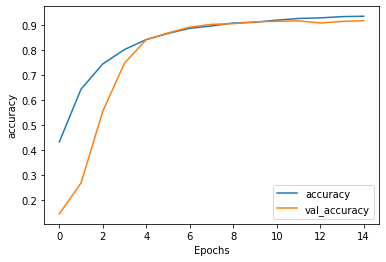

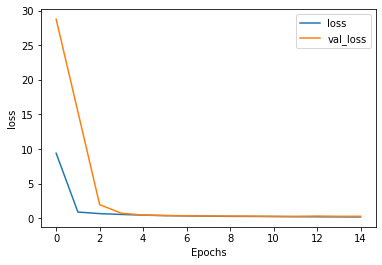

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, "loss")

In [ ]:
preds = model.evaluate(val_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

47/47 [==============================] - 13s 267ms/step - loss: 0.2723 - accuracy: 0.9173
Loss = 0.2722928822040558
Test Accuracy = 0.9173333048820496
